In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preparing the data for analysis

### Examining the dataset

In [2]:
ri = pd.read_csv('rhode_island.csv', low_memory=False)[['date','time','subject_sex',
                                                        'subject_race','reason_for_stop','search_conducted',
                                                        'reason_for_search','outcome','arrest_made',
                                                        'contraband_drugs', 'zone']]

In [3]:
ri.rename({'date':'stop_date', 'time':'stop_time', 'subject_sex':'driver_gender',
           'subject_race':'driver_race', 'reason_for_stop':'violation', 'reason_for_search':'search_type',
           'outcome':'stop_outcome', 'arrest_made':'is_arrested', 'contraband_drugs':'drugs_related_stop', 'zone':'district'},axis=1,inplace=True)

In [4]:
ri.head()

,stop_date,stop_time,driver_gender,driver_race,violation,search_conducted,search_type,stop_outcome,is_arrested,drugs_related_stop,district
0,2005-11-22,11:15:00,male,white,Speeding,False,NaN,citation,False,NaN,X3
1,2005-10-01,12:20:00,male,white,Speeding,False,NaN,citation,False,NaN,X3
2,2005-10-01,12:30:00,female,white,Speeding,False,NaN,citation,False,NaN,X3
3,2005-10-01,12:50:00,male,white,Speeding,False,NaN,citation,False,NaN,X3
4,2005-10-01,13:10:00,female,white,Speeding,False,NaN,citation,False,NaN,X3


In [5]:
ri.shape

(509681, 11)

### Drop and fill null data

In [6]:
ri.isnull().sum()

stop_date                 10
stop_time                 10
driver_gender          29097
driver_race            29073
violation              29073
search_conducted           0
search_type           491919
stop_outcome           35841
is_arrested            29073
drugs_related_stop    493693
district                  10
dtype: int64

In [7]:
ri.dropna(subset=['driver_gender','stop_outcome'],inplace=True)

In [8]:
ri.fillna(value={'drugs_related_stop':False},inplace=True)

In [9]:
ri.isnull().sum()

stop_date                  0
stop_time                  0
driver_gender              0
driver_race                0
violation                  0
search_conducted           0
search_type           456490
stop_outcome               0
is_arrested                0
drugs_related_stop         0
district                   0
dtype: int64

In [10]:
ri.search_conducted.value_counts()

False    456490
True      17331
Name: search_conducted, dtype: int64

This explains why there are so many unknown search types. It's because the search itself is not even conducted.

### Fixing data types

In [11]:
ri.dtypes

stop_date             object
stop_time             object
driver_gender         object
driver_race           object
violation             object
search_conducted        bool
search_type           object
stop_outcome          object
is_arrested           object
drugs_related_stop      bool
district              object
dtype: object

In [12]:
ri['is_arrested'] = ri.is_arrested.astype('bool')

In [13]:
ri.is_arrested.dtypes

dtype('bool')

In [14]:
ri['stop_datetime'] = pd.to_datetime(ri.stop_date.str.cat(ri.stop_time, sep=' '))
ri.set_index('stop_datetime', inplace=True)
ri.drop(columns=['stop_date','stop_time'], inplace=True)

In [15]:
ri.head()

,driver_gender,driver_race,violation,search_conducted,search_type,stop_outcome,is_arrested,drugs_related_stop,district
stop_datetime,,,,,,,,,
2005-11-22 11:15:00,male,white,Speeding,False,NaN,citation,False,False,X3
2005-10-01 12:20:00,male,white,Speeding,False,NaN,citation,False,False,X3
2005-10-01 12:30:00,female,white,Speeding,False,NaN,citation,False,False,X3
2005-10-01 12:50:00,male,white,Speeding,False,NaN,citation,False,False,X3
2005-10-01 13:10:00,female,white,Speeding,False,NaN,citation,False,False,X3


# Exploring the relationship between gender and policing

- Do the genders commit different violations?
- Does gender affect who gets a ticket for speeding?
- Does gender affect whose vehicle is searched?
- Does gender affect who is frisked during a search?

### Examining traffic violations

In [16]:
ri.violation.value_counts()

Speeding                            268203
Other Traffic Violation              89600
Equipment/Inspection Violation       58249
Registration Violation               19598
Seatbelt Violation                   16271
Special Detail/Directed Patrol       13456
Call for Service                      6288
Violation of City/Town Ordinance      1020
APB                                    445
Motorist Assist/Courtesy               365
Suspicious Person                      221
Warrant                                105
Name: violation, dtype: int64

In [17]:
ri.violation.value_counts(normalize=True)

Speeding                            0.566043
Other Traffic Violation             0.189101
Equipment/Inspection Violation      0.122935
Registration Violation              0.041362
Seatbelt Violation                  0.034340
Special Detail/Directed Patrol      0.028399
Call for Service                    0.013271
Violation of City/Town Ordinance    0.002153
APB                                 0.000939
Motorist Assist/Courtesy            0.000770
Suspicious Person                   0.000466
Warrant                             0.000222
Name: violation, dtype: float64

### Comparing violations by gender

In [18]:
female = ri[ri.driver_gender=='female']
male = ri[ri.driver_gender=='male']

print(female.violation.value_counts(normalize=True).head(5))
print(male.violation.value_counts(normalize=True).head(5))

Speeding                          0.666050
Other Traffic Violation           0.137567
Equipment/Inspection Violation    0.102869
Registration Violation            0.043379
Seatbelt Violation                0.027424
Name: violation, dtype: float64
Speeding                          0.528537
Other Traffic Violation           0.208428
Equipment/Inspection Violation    0.130460
Registration Violation            0.040605
Special Detail/Directed Patrol    0.037131
Name: violation, dtype: float64


About two-thirds of female traffic stops are for speeding, whereas stops of males are more balanced among all categories. This doesn't mean that females speed more often than males, however, since we didn't take into account the number of stops or drivers.

### Comparing speeding outcomes by gender

In [19]:
female_and_speeding = ri[(ri.driver_gender=='female')&(ri.violation=='Speeding')]
male_and_speeding = ri[(ri.driver_gender=='male')&(ri.violation=='Speeding')]

print(female_and_speeding.stop_outcome.value_counts(normalize=True))
print(male_and_speeding.stop_outcome.value_counts(normalize=True))

citation    0.954609
warning     0.039059
arrest      0.006332
Name: stop_outcome, dtype: float64
citation    0.946763
warning     0.036167
arrest      0.017070
Name: stop_outcome, dtype: float64


The numbers are similar for males and females: about 95% of stops for speeding result in a ticket. Thus, the data fails to show that gender has an impact on who gets a ticket for speeding.

### Comparing search rates by gender

In [20]:
ri.groupby('driver_gender').search_conducted.mean()

driver_gender
female    0.018556
male      0.043336
Name: search_conducted, dtype: float64

Male drivers are searched more than twice as often as female drivers

In [21]:
ri.groupby(['violation','driver_gender']).search_conducted.mean()

violation                         driver_gender
APB                               female           0.168317
                                  male             0.270349
Call for Service                  female           0.054114
                                  male             0.106768
Equipment/Inspection Violation    female           0.040394
                                  male             0.071471
Motorist Assist/Courtesy          female           0.119048
                                  male             0.202847
Other Traffic Violation           female           0.037462
                                  male             0.058130
Registration Violation            female           0.053871
                                  male             0.101987
Seatbelt Violation                female           0.017777
                                  male             0.031429
Special Detail/Directed Patrol    female           0.018154
                                  male             0

### Comparing frisk rates by gender

In [22]:
ri.search_type.value_counts()

Incident to Arrest                                          6810
Probable Cause                                              2042
Odor of Drugs/Alcohol                                       1824
Reasonable Suspicion                                        1105
Inventory/Tow                                               1083
                                                            ... 
Incident to Arrest|Terry Frisk|Plain View                      1
Inventory/Tow|Plain View|Probable Cause                        1
Terry Frisk|Incident to Arrest|Odor of Drugs/Alcohol           1
Inventory/Tow|Odor of Drugs/Alcohol|Reasonable Suspicion       1
Odor of Drugs/Alcohol|Reasonable Suspicion|Inventory/Tow       1
Name: search_type, Length: 187, dtype: int64

In [23]:
ri['frisk'] = ri.search_type.str.contains('Terry Frisk', na=False)
ri.frisk.sum()

1560

In [24]:
searched = ri[ri.search_conducted == True]
searched.groupby('driver_gender').frisk.mean()

driver_gender
female    0.065888
male      0.093886
Name: frisk, dtype: float64

The frisk rate is higher for males than for females, though we can't conclude that this difference is caused by the driver's gender.

# Visual Exploratory Data Analysis

- Does time of day affect arrest rate?
- Are drug-related stops on the rise?
- What violations are caught in each district?

### Hourly arrest rate

In [25]:
hourly_arrest_rate = ri.groupby(ri.index.hour).is_arrested.mean()

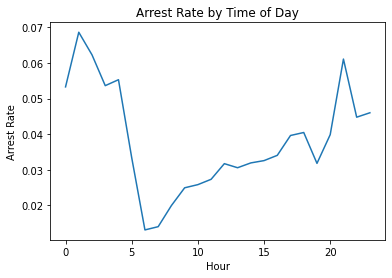

In [26]:
hourly_arrest_rate.plot()
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')
plt.show()

### Comparing drug and search rates

In [27]:
annual_drug_rate = ri.drugs_related_stop.resample('A').mean()
annual_search_rate = ri.search_conducted.resample('A').mean()
annual = pd.concat([annual_drug_rate, annual_search_rate], axis=1)

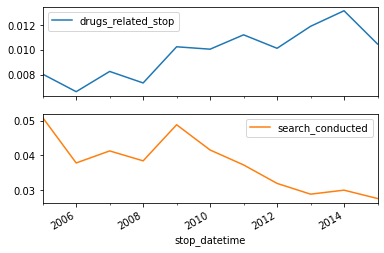

In [28]:
annual.plot(subplots=True)
plt.show()

The rate of drug-related stops increased even though the search rate decreased

### Violations by district

In [29]:
all_zones = pd.crosstab(ri.district, ri.violation)
k_zones = all_zones.loc['K1':'K3']

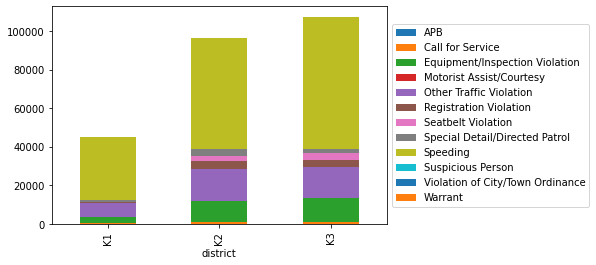

In [30]:
k_zones.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()